# Teaching a Variational Autoencoder (VAE) to draw MNIST characters

Autoencoders are a type of neural network that can be used to learn efficient codings of input data. 
Given some inputs, the network firstly applies a series of transformations that map the input data into a lower dimensional space. This part of the network is called the _encoder_. Then, the network uses the encoded data to try and recreate the inputs. This part of the network is the _decoder_. Using the encoder, we can later compress data of the type that is understood by the network. However, autoencoders are rarely used for this purpose, as usually there exist hand-crafted algorithms (like _jpg_-compression) that are more efficient. Instead, autoencoders have repeatedly been applied to perform denoising tasks. Then, the encoder receives pictures that have been tampered with noise, and it learns how to reconstruct the original images.


## Variational Autoencoders put simply
But there exists a much more interesting application for autoencoders. This application is called the _variational autoencoder_. Using variational autoencoders, it's not only possible to compress data -- it's also possible to generate new objects of the type the autoencoder has seen before.

Using a general autoencoder, we don't know anything about the coding that's been generated by our network. We could take a look at and compare different encoded objects, but it's unlikely that we'll be able to understand what's going on. This means that we won't be able to use our decoder for creating new objects -- we simply don't know what the inputs should look like.

Using a variational autoencoder, we take the opposite approach instead. We will not try to make guesses concerning the distribution that's being followed by the latent vectors. We simply tell our network what we want this distribution to look like. Usually, we will constrain the network to produce latent vectors having entries that follow the unit normal distribution. Then, when trying to generate data, we can simply sample some values from this distribution, feed them to the decoder, and the decoder will return us completely new objects that appear just like the objects our network has been trained with.

Let's see how this can be done using python and tensorflow. We are going to teach our network how to draw MNIST characters.

## First steps -- Loading the training data
Firstly, we perform some basic imports. Tensorflow has a quite handy function that allows us to easily access the MNIST data set.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Defining our input and output data
MNIST images have a dimension of 28 * 28 pixels with one color channel. Our inputs _X_in_ will be batches of MNIST characters, while our network will learn to reconstruct them and output them in a placeholder _Y_, which thus has the same dimensions. _Y_flat_ will be used later, when computing losses. _keep_prob_ will be used when applying dropouts as a means of regularization. During training, it will have a value of 0.8. When generating new data, we won't apply dropout, so the value will be 1. The function _lrelu_ is being defined as tensorflow unfortunately doesn't come up with a predefined leaky ReLU.

In [ ]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

## Defining the encoder
As our inputs are images, it's most reasonable to apply some convolutional transformations to them. What's most noteworthy is the fact that we are creating two vectors in our encoder, as the encoder is supposed to create objects following a Gaussian Distribution:
* A vector of means
* A vector of standard deviations

You will see later how we "force" the encoder to make sure it really creates values following a Normal Distribution. The returned values that will be fed to the decoder are the _z_-values. We will need the mean and standard deviation of our distributions later, when computing losses. 

In [135]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

## Defining the decoder
The decoder does not care about whether the input values are sampled from some specific distribution that has been defined by us. It simply will try to reconstruct the input images. To this end, we use a series of transpose convolutions.

In [ ]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

Now, we'll wire together both parts:

In [136]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

## Computing losses and enforcing a Gaussian latent distribution
For computing the image reconstruction loss, we simply use squared difference (which could lead to images sometimes looking a bit fuzzy). This loss is combined with the _Kullback-Leibler divergence_, which makes sure our latent values will be sampled from a normal distribution. For more on this topic, please take a look a Jaan Altosaar's great article on VAEs. 

In [137]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training the network
Now, we can finally train our VAE! Every 200 steps, we'll take a look at what the current reconstructions look like. After having processed about 2000 batches, most reconstructions will look reasonable.

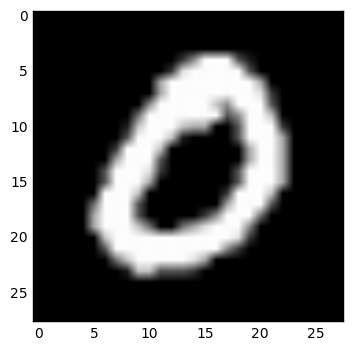

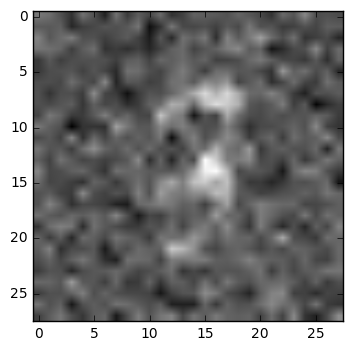

(0, 177.71252, 177.70801, 0.0045222375)


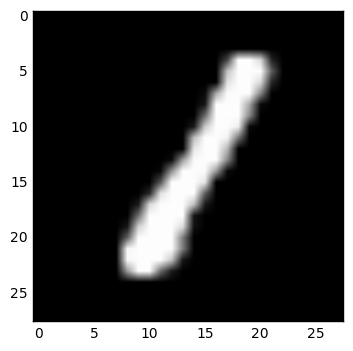

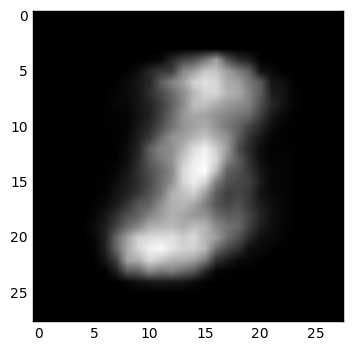

(200, 48.203644, 46.254406, 1.9492408)


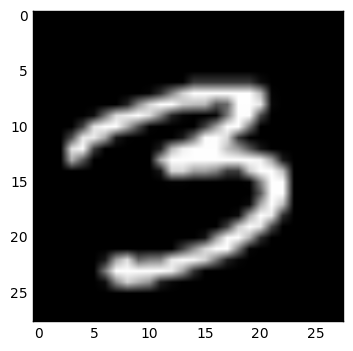

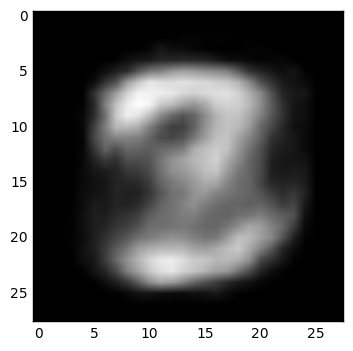

(400, 38.237137, 32.45359, 5.7835445)


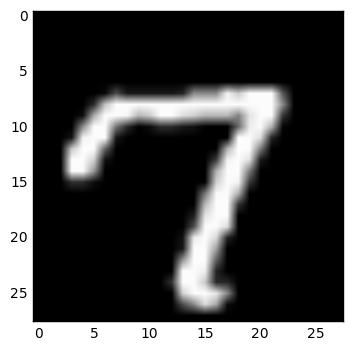

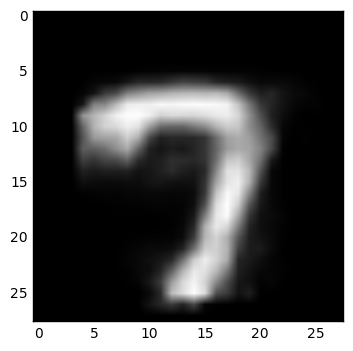

(600, 36.103294, 28.312752, 7.7905412)


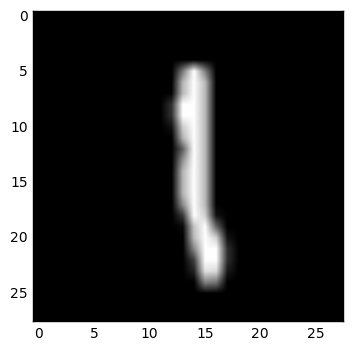

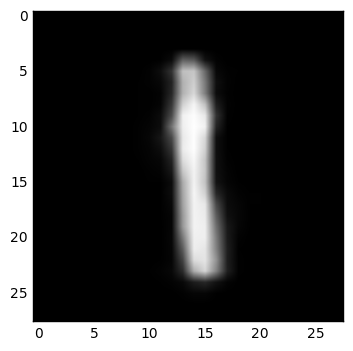

(800, 33.193581, 25.198124, 7.9954529)


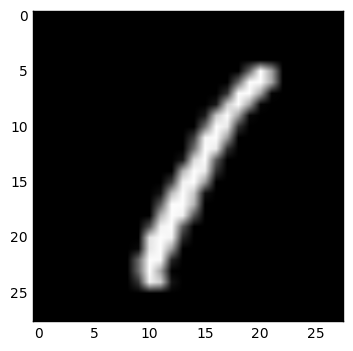

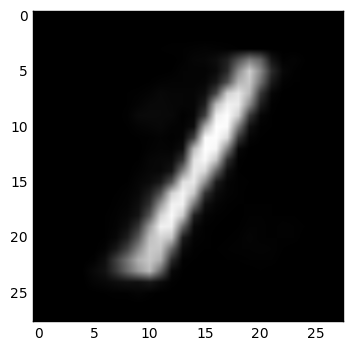

(1000, 31.679817, 22.834435, 8.8453846)


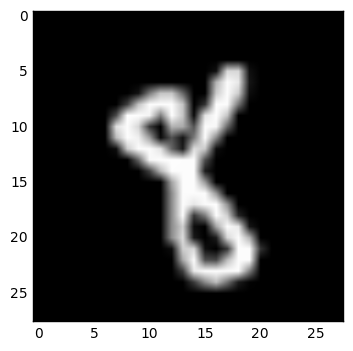

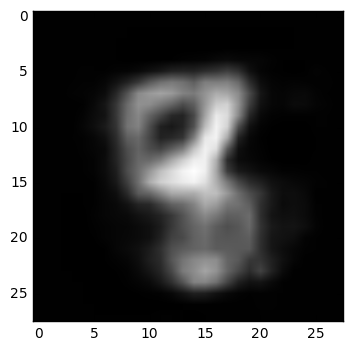

(1200, 32.780701, 24.022045, 8.7586584)


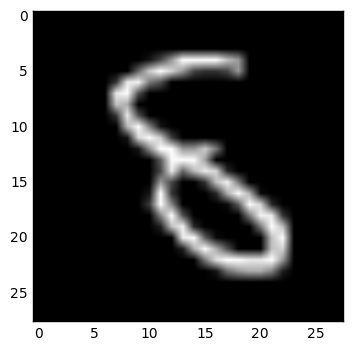

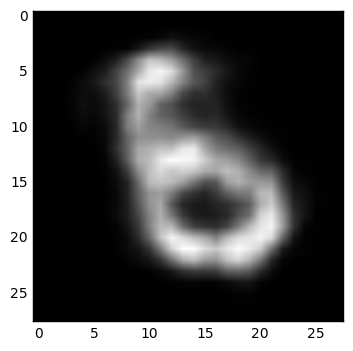

(1400, 31.247265, 22.307117, 8.9401474)


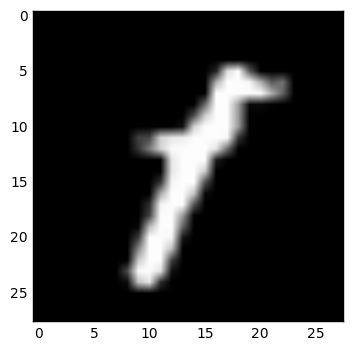

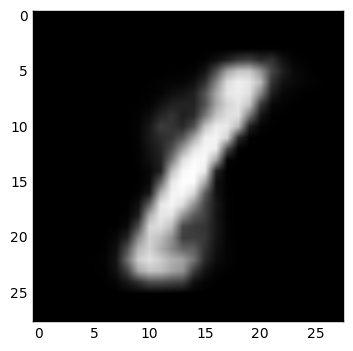

(1600, 32.54533, 23.790714, 8.7546167)


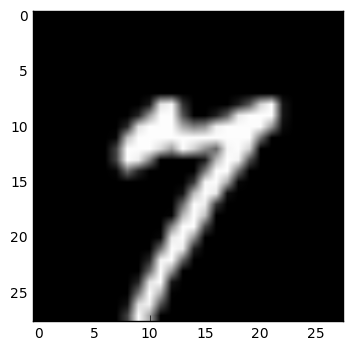

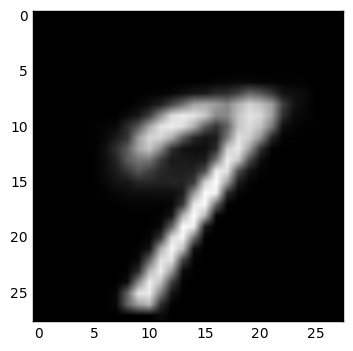

(1800, 33.551231, 24.434624, 9.1166086)


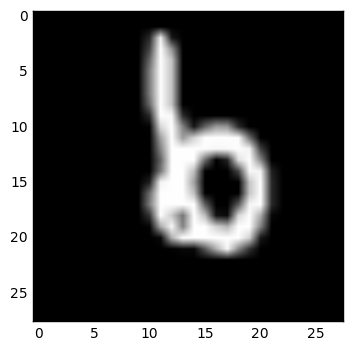

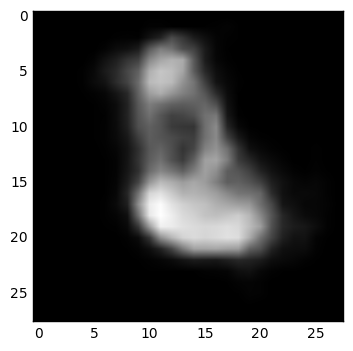

(2000, 32.551483, 22.994276, 9.5572071)


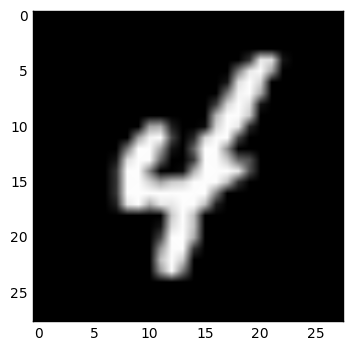

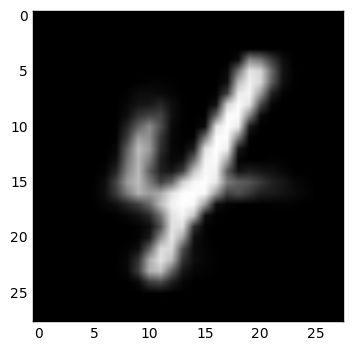

(2200, 30.697153, 21.612953, 9.084199)


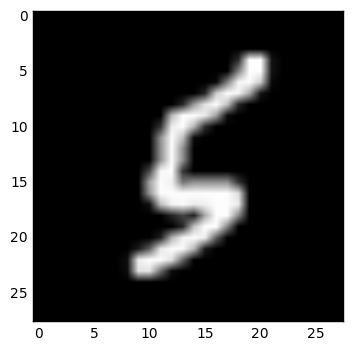

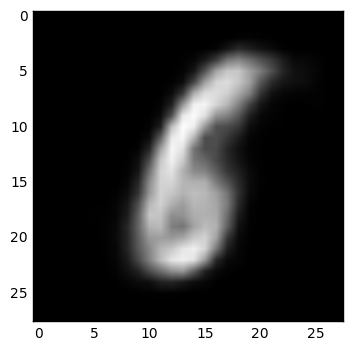

(2400, 30.428909, 20.774357, 9.6545525)


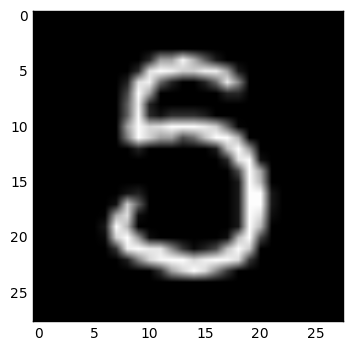

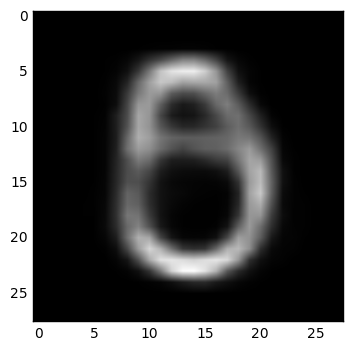

(2600, 31.834841, 22.858143, 8.9766989)


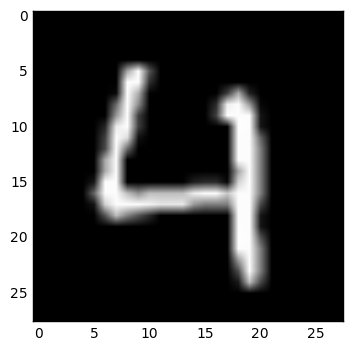

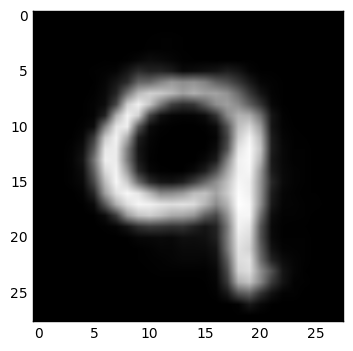

(2800, 29.906328, 20.382608, 9.5237188)


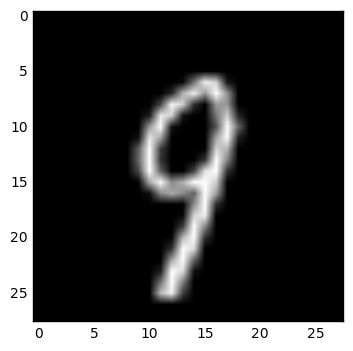

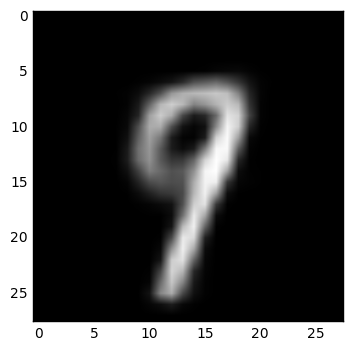

(3000, 28.873055, 19.336117, 9.5369387)


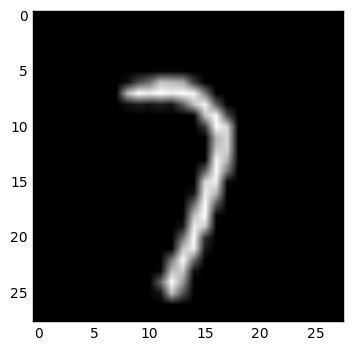

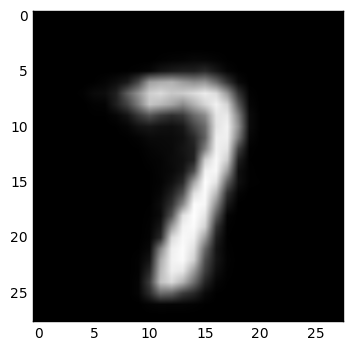

(3200, 30.283049, 21.494888, 8.7881584)


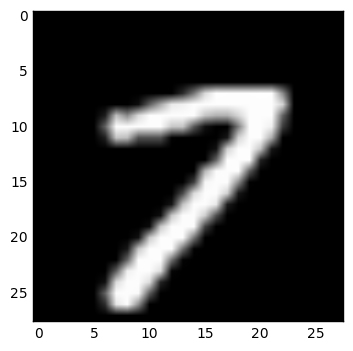

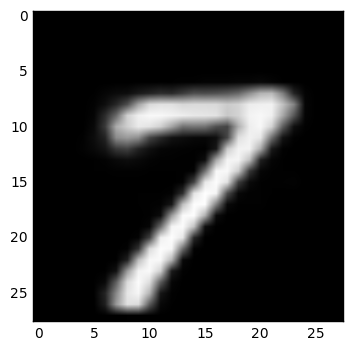

(3400, 31.130566, 20.909546, 10.22102)


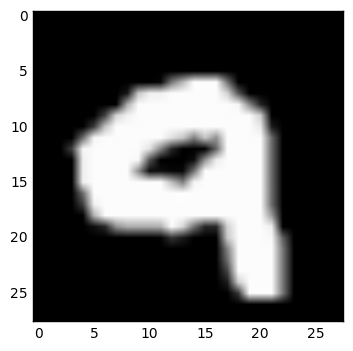

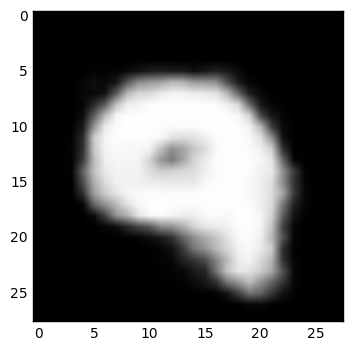

(3600, 30.292824, 19.819916, 10.47291)


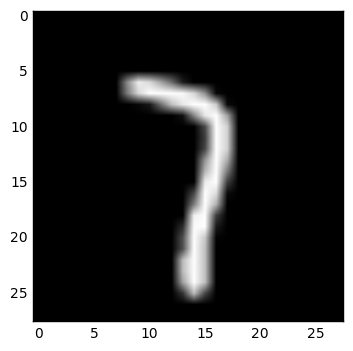

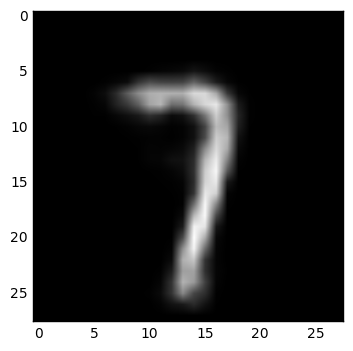

(3800, 30.582977, 21.229332, 9.3536472)


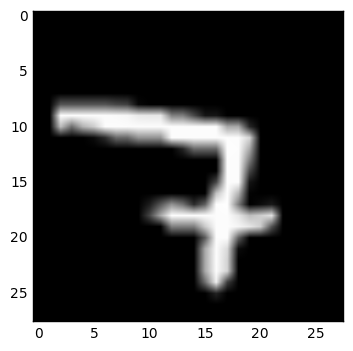

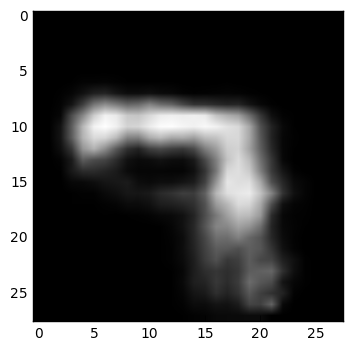

(4000, 31.873409, 22.566912, 9.3064966)


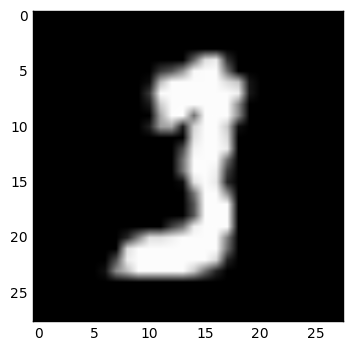

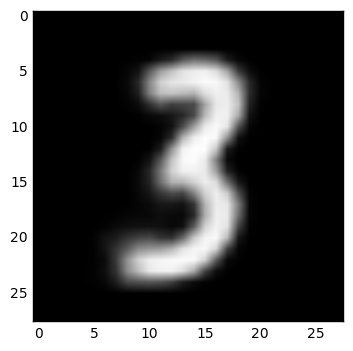

(4200, 29.518877, 19.516506, 10.00237)


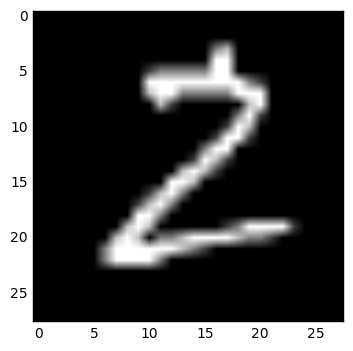

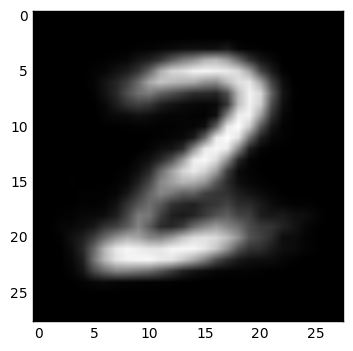

(4400, 27.225649, 18.022957, 9.2026911)


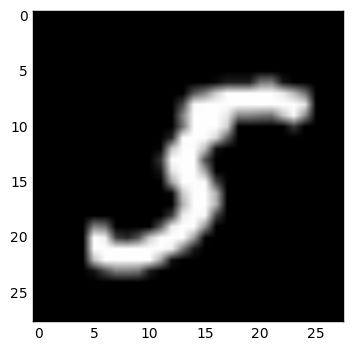

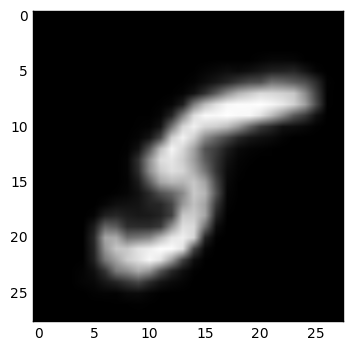

(4600, 29.31242, 19.869308, 9.4431152)


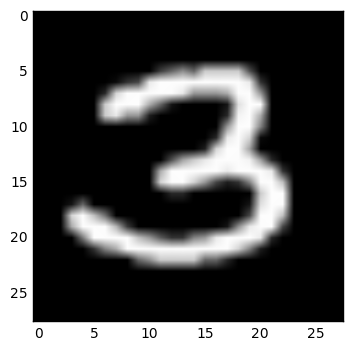

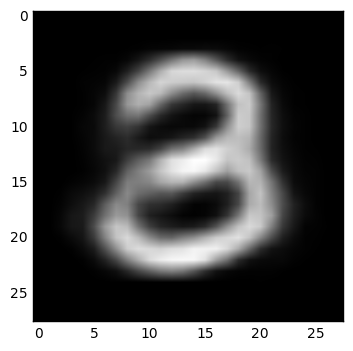

(4800, 30.48785, 20.463566, 10.024285)


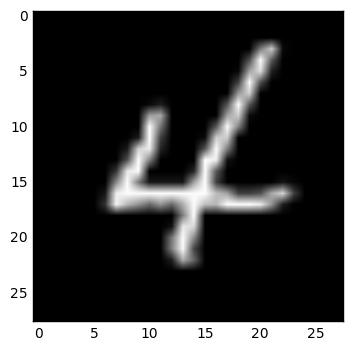

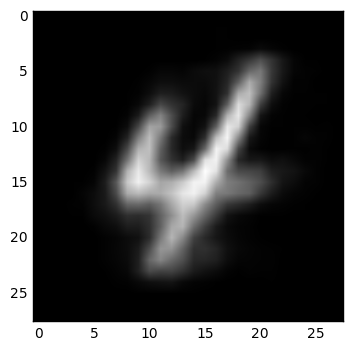

(5000, 30.257076, 20.249451, 10.007625)


KeyboardInterrupt: 

In [140]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, dst_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

## Generating new data
The most awesome part is that we are now able to create new characters. To this end, we simply sample values from a unit normal distribution and feed them to our decoder. Most of the created characters look just like they've been written by humans.  

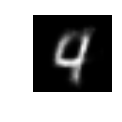

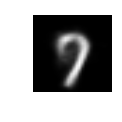

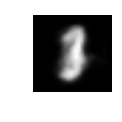

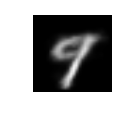

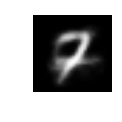

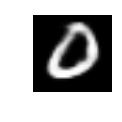

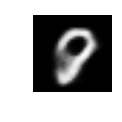

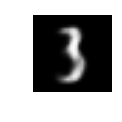

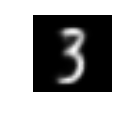

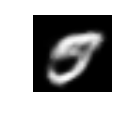

In [191]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

## Conclusion
Now, this obviously is a relatively simple example of an application of VAEs. But just think about what could be possible! Neural networks could learn to compose music. They could automatically create illustrations for books, games etc. With a bit of creativity, VAEs will open up space for some awesome projects 